In [1]:
def Stock_Forecast(Instrument, TRIAL, PATIENCE, Back):
    #importing required libraries
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, LSTM
    import pandas as pd
    import numpy as np
    import datetime
    
    import tensorflow as tf
    import random as rn
    import os

    os.environ['PYTHONHASHSEED'] = '0'

    # Setting the seed for numpy-generated random numbers
    np.random.seed(37)

    # Setting the seed for python random numbers
    rn.seed(1254)

    # Setting the graph-level random seed.
    tf.set_random_seed(89)

    from keras import backend as K

    session_conf = tf.ConfigProto(
          intra_op_parallelism_threads=1,
          inter_op_parallelism_threads=1)

    #Force Tensorflow to use a single thread
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

    K.set_session(sess)
    
    # read the data
    d=pd.read_excel("Book3.xlsx")
    
    # remove leading and trainling blank spaces from column names
    d.columns=d.columns.str.strip()
    
    # remove leanding and trailing blank spaces from TRADING CODEs
    d['TRADING CODE']=d['TRADING CODE'].str.strip()
    
    # select the Instrument of your interest
    df=d[d['TRADING CODE']==Instrument]
    
    # remove rows with invalid values
    df=df[~(df['LTP']==0)|(df['HIGH']==0)|(df['LOW']==0)|(df['OPENP']==0)|(df['CLOSEP']==0)]
    
    # remove rows with invalid values
    df=df[~(df['LTP']==0)|(df['HIGH']==0)|(df['LOW']==0)|(df['OPENP']==0)|(df['CLOSEP']==0)]
    
    # sort the data as per date
    df=df.sort_values(['DATE'], ascending=True)
    
    # keep only the required columns
    dx=df[['DATE', 'CLOSEP']]
    
    # set the date column as index
    dx.set_index(['DATE'], inplace=True)
    
    # turn the column into a numpy array
    dataset=dx.values
    
    # set first 75% values as training data and the rest as test data
    train = dataset[:int(len(dataset)*.85),:]
    valid = dataset[int(len(dataset)*.85):,:]
    
    # scaling the values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    # creating x_train and y_train, seeting the array as 0 dimensional, each time x_train.append is giving 'Back' values with 0 dimension,then set each as 
    # rows
    x_train, y_train = [], []
    for i in range (Back,len(train)):
        x_train.append(scaled_data[i-Back:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # turn x_train as three dimensional
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    
    # compile the model
    import keras
    from keras.models import load_model
    
    # set the model saved file name
    fn=Instrument+'weights.hdf5'
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # model will try to minimize mape
    ks = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=PATIENCE) # model will wait for the next 200 model, if no improvement, stop
    checkpointer = keras.callbacks.ModelCheckpoint(filepath=fn, monitor='loss', verbose=0, save_best_only=True) # best model so far will be saved
    model.fit(x_train, y_train, epochs=TRIAL, validation_split=0.1, verbose=0, callbacks=[ks, checkpointer]) # now the fitted model will run 4000 trials for best model
    model=load_model(fn) # now the best model will be loaded from saved file

    #predicting values, using past 'Back' from the train data
    inputs = dx.values[len(dx) - len(valid) - Back:]
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    
    # creating X_test
    X_test = []
    for i in range(Back,inputs.shape[0]):
        X_test.append(inputs[i-Back:i,0])
    X_test = np.array(X_test)
    
    # turn X_test into 3 dimensional
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    # forecasting future values ie calculating y_test
    closing_price = model.predict(X_test)
    cl=closing_price

    # turning the forecasting values back to original scale
    closing_price = scaler.inverse_transform(closing_price)
    
    # model evaluate
    train_acc = model.evaluate(x_train, y_train, verbose=0)
    test_acc = model.evaluate(X_test, cl, verbose=0)
    #print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
        
    # calculating MAPE
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    mape=sum(abs(valid-closing_price)/abs(valid))*100*(1/len(valid))
    
    #to plot within notebook
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    # for plotting
    plt.figure(figsize=(20,10))
    train = dx[:int(len(dataset)*.85)]
    valid = dx[int(len(dataset)*.85):]
    valid['Predictions'] = closing_price
    plt.plot(train['CLOSEP'])
    plt.plot(valid[['CLOSEP','Predictions']])
    
    print('The Root Mean Squared of the Model is: %.3f' %(rms))
    print('The Mean Absolute Percentage Error of the Model is: %.3f' %(mape))
    
    # out of sample forecast, next 30 business days
    se=scaled_data[-Back:] # take last 'Back' values
    st=se.reshape((1, Back, 1)) # reshape
    yhat=np.zeros(shape=(30,1)) # run for loop for creating one forecast at a time and then use it to forecast the next
    for i in range(0,30):
        yhat[i] = model.predict(st, verbose=0)
        st=np.append(st, yhat[i])[-Back:].reshape(1,Back,1)
        
    yx= scaler.inverse_transform(yhat) # inverse the variable transformation
    yx=np.concatenate(yx).ravel().tolist() # unlist the forecast data
    yx=[round(w, 1) for w in yx] # rounding the data to .10
    
    # create the date index of the forecasted values
    weekmask = 'Sun Mon Tue Wed Thu'
    custombday = pd.offsets.CustomBusinessDay(weekmask=weekmask)
    pday=pd.bdate_range(start=df.iloc[dx.shape[0]-1, 0]+datetime.timedelta(days=1), end=df.iloc[dx.shape[0]-1, 0]+datetime.timedelta(days=365), freq=custombday ).tolist()[0:30]
   
    # turn the forecasted values into a dataframe
    xp=pd.DataFrame({'Date':pday, 'Forecast':yx})
    xp.set_index('Date', inplace=True)
    
    # plot the forecast
    plt.figure(figsize=(20,10))
    plt.plot(xp['Forecast'])
    
    # now plot the forecast along with the original data
    zx=pd.merge(valid, xp, left_index=True, right_index=True, how='outer')
    plt.figure(figsize=(20,10))
    plt.plot(zx[['CLOSEP', 'Forecast']])
    
    # the forecasted data as a output
    return(xp)

Epoch 00789: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The Root Mean Squared of the Model is: 0.552
The Mean Absolute Percentage Error of the Model is: 1.119


,Forecast
Date,
2019-02-26,39.9
2019-02-27,39.9
2019-02-28,39.8
2019-03-03,39.8
2019-03-04,39.7
2019-03-05,39.6
2019-03-06,39.4
2019-03-07,39.1
2019-03-10,38.8


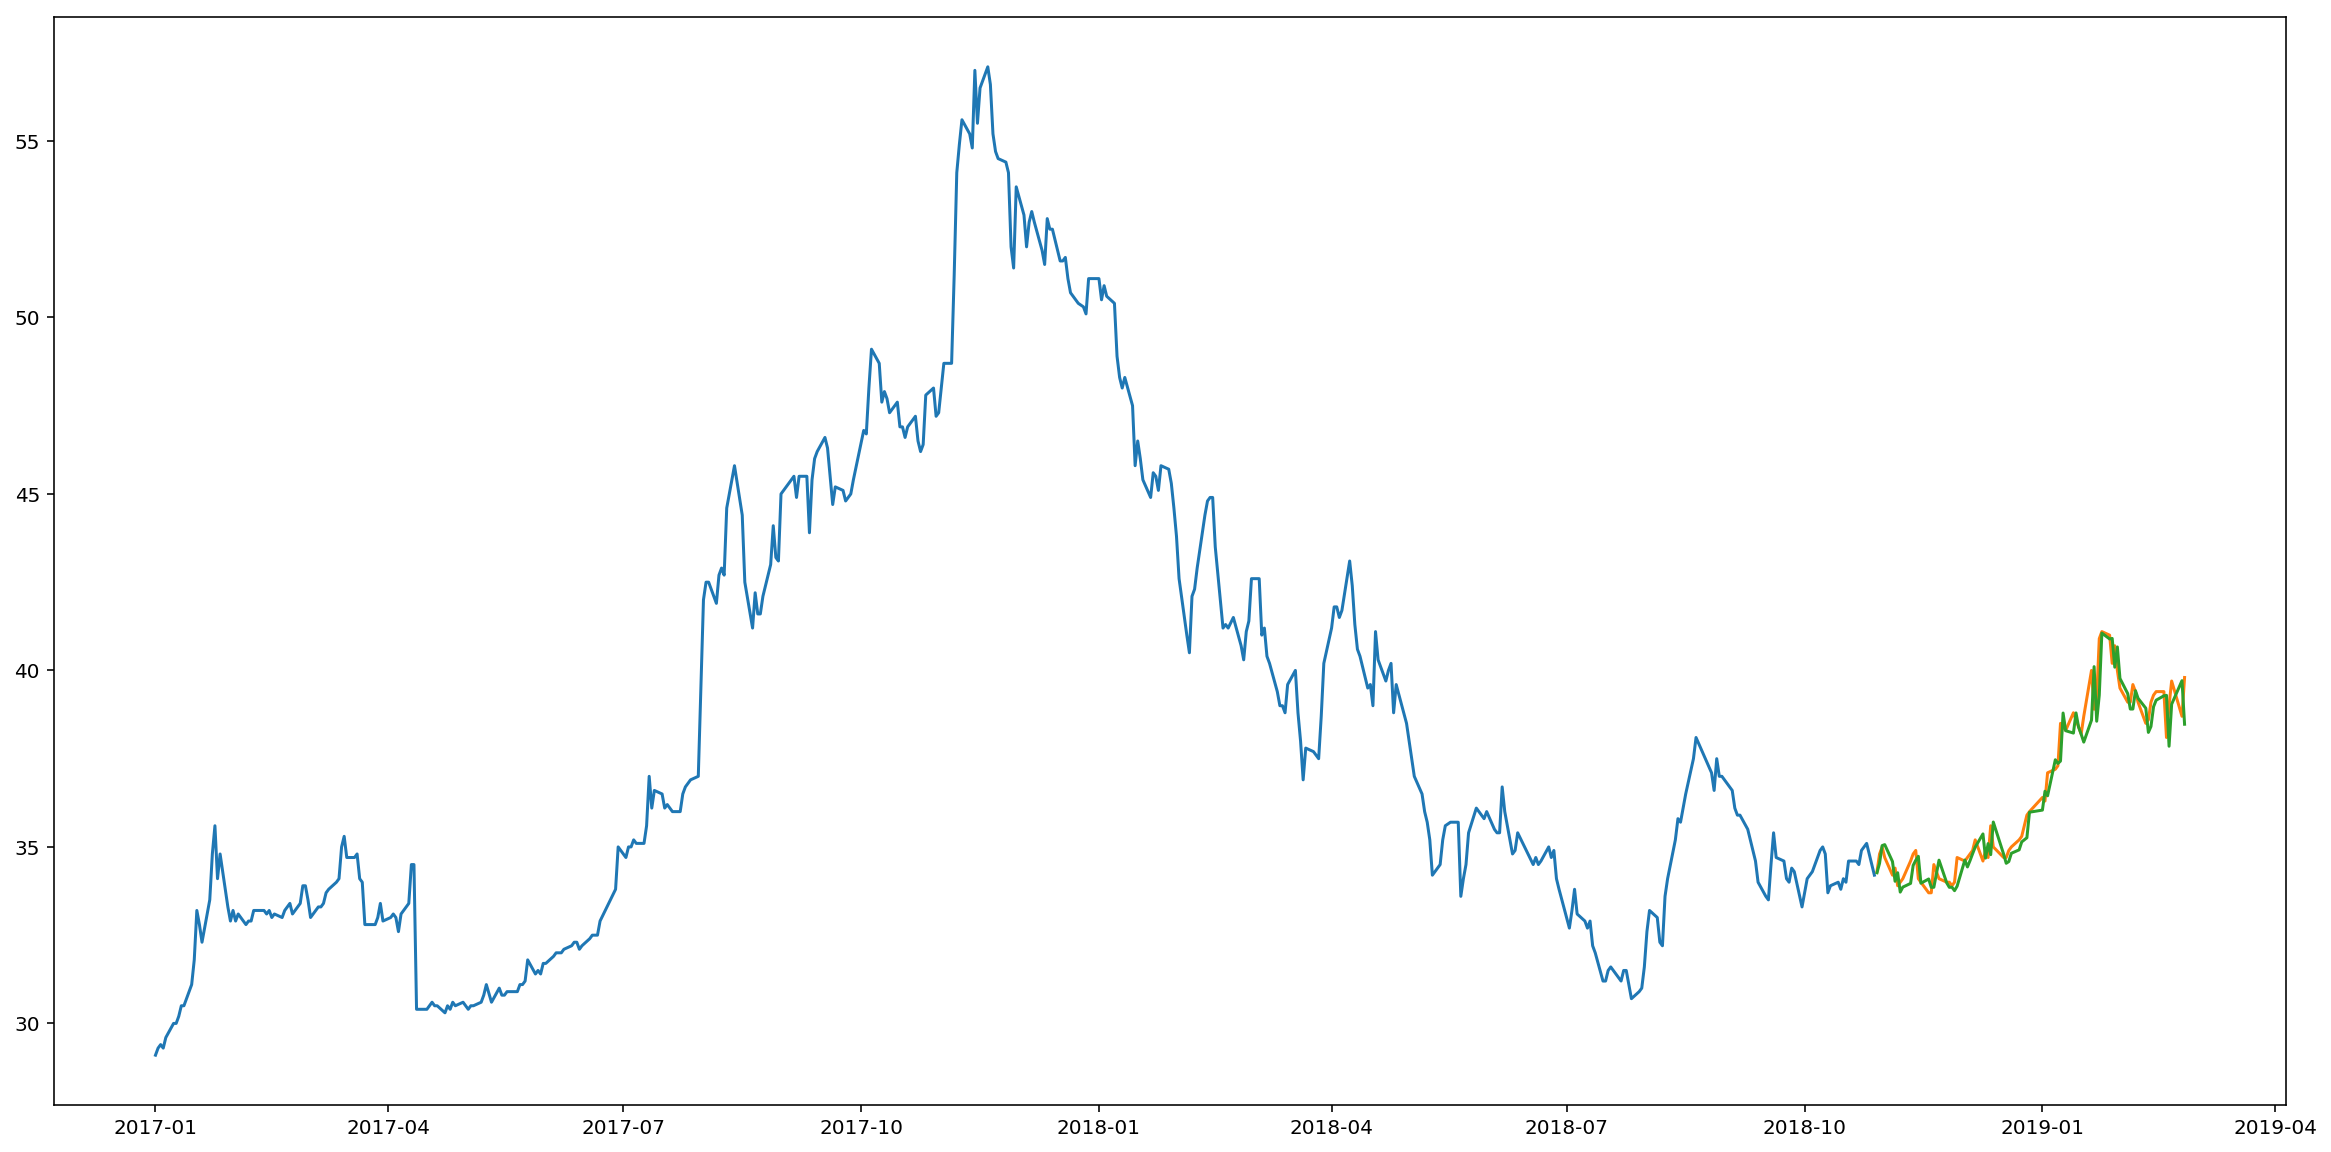

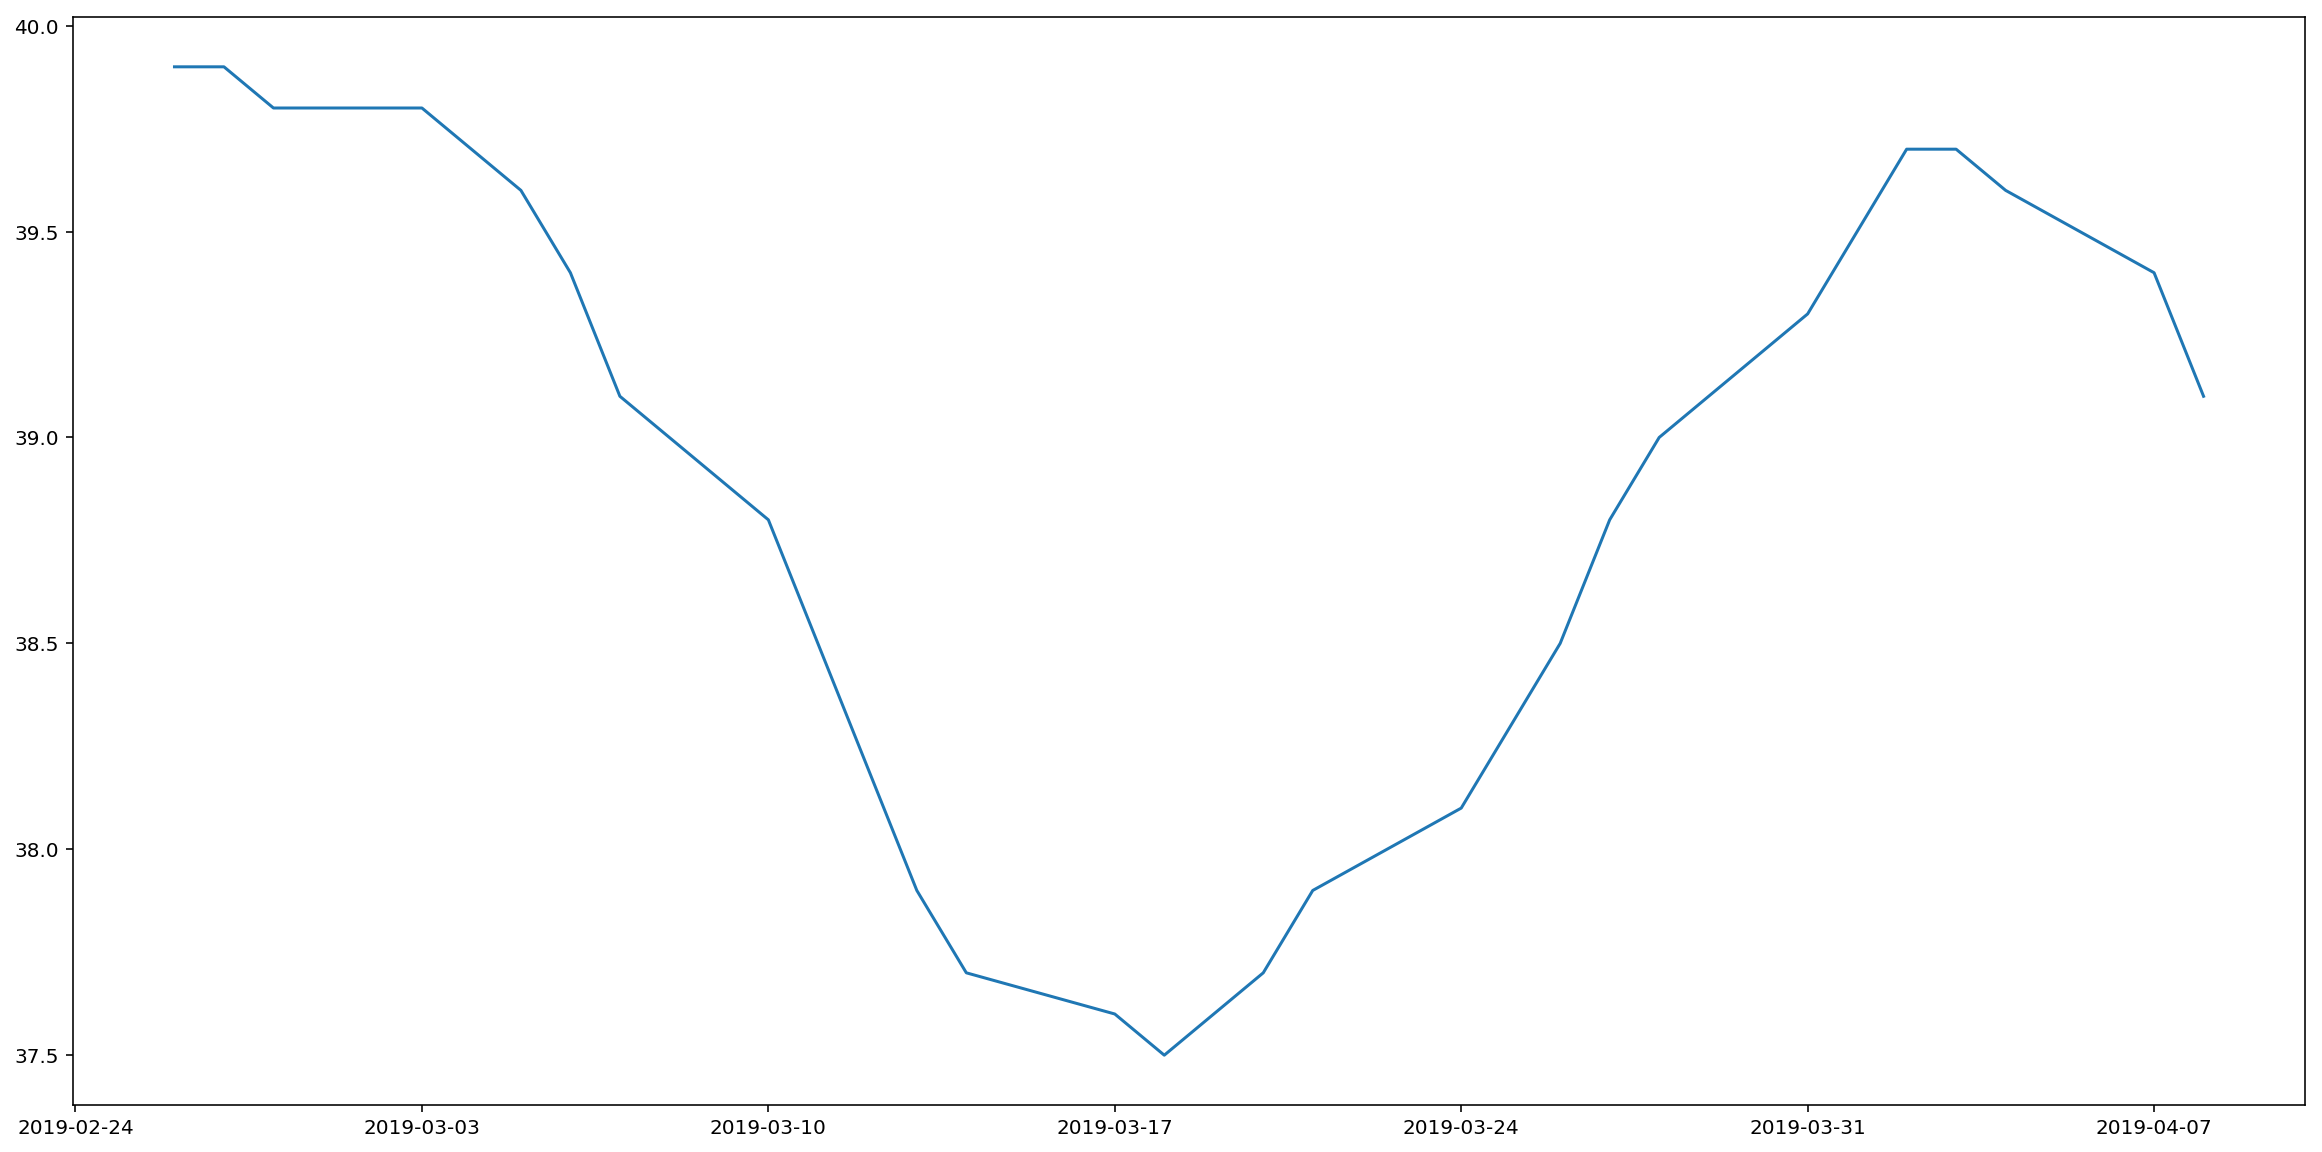

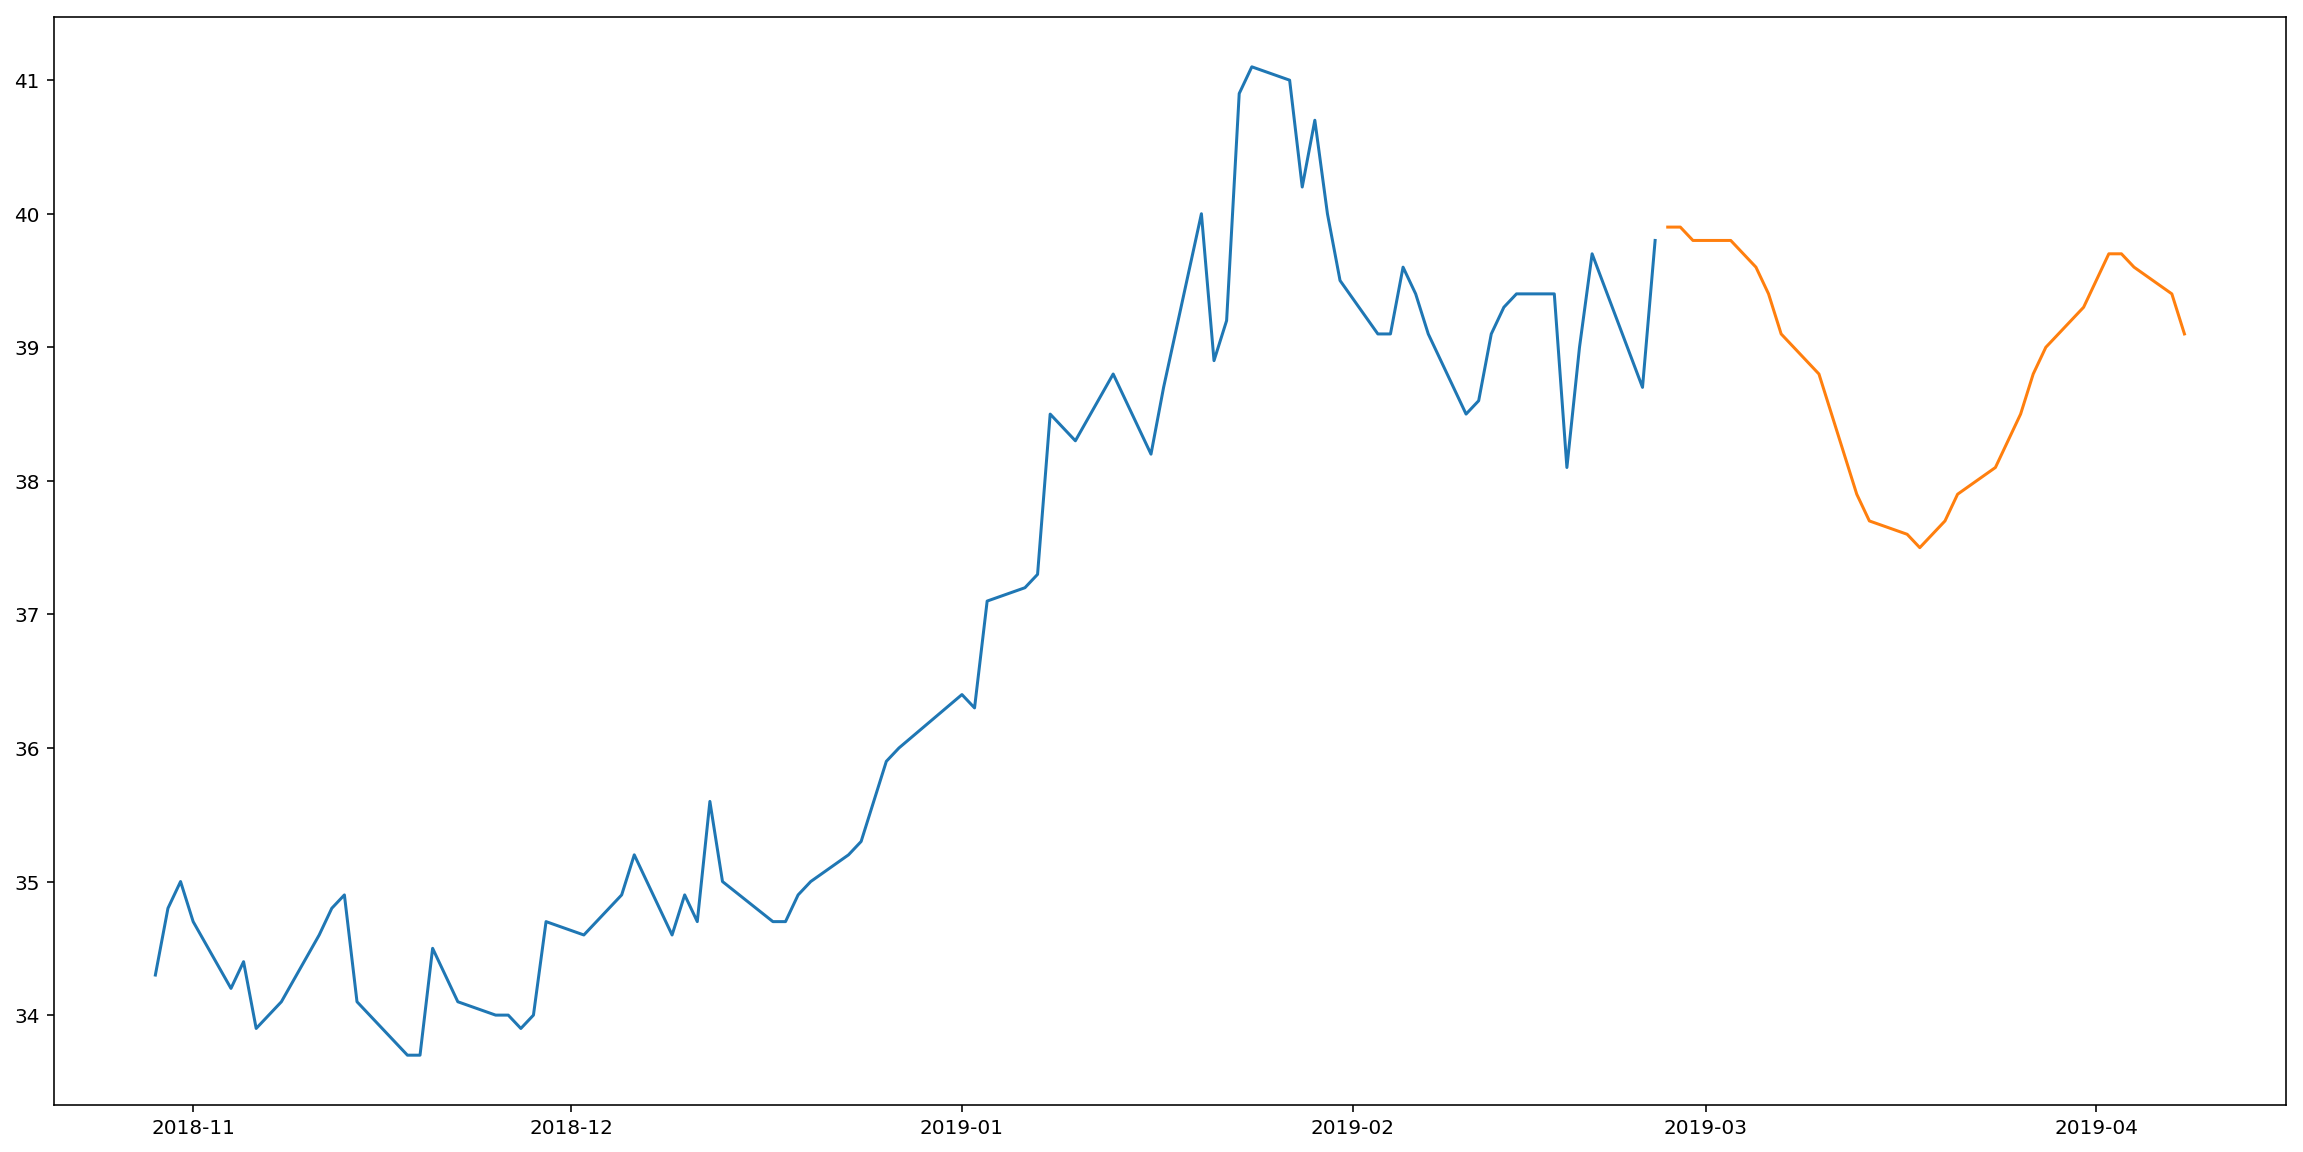

In [3]:
# input Instrument Name
# number of Epoch (trials),
# after how many trials without any improvement in result the system should stop trial
# number of previous data points to use for forecasting
Stock_Forecast(Instrument='EBL', TRIAL=4000, PATIENCE= 500, Back=60)